In [1]:
import os
from datasets import load_dataset
import helper_utils as utils
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
print(tf.__version__)

/home/omar/TUM/05_projects/2D-Object-Detection/objDet/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-09-20 17:06:22.967414: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-20 17:06:23.183470: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-20 17:06:23.183537: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been register

2.15.0


# 0 Data preperation

In [16]:
import os
from PIL import Image
import json
from datasets import load_dataset

# Load the dataset
ds = load_dataset("keremberke/football-object-detection")

# Create directories for saving images and annotations
image_dir = "./football_dataset/val/images"
annotations_dir = "./football_dataset/val/annotations"
os.makedirs(image_dir, exist_ok=True)
os.makedirs(annotations_dir, exist_ok=True)

# Save the dataset locally
for i, item in enumerate(ds['validation']):
    # Save image (directly save the PIL image)
    image = item['image']  # 'image' is already a PIL.JpegImageFile object
    image_path = os.path.join(image_dir, f"{i}.png")
    image.save(image_path)
    
    # Save annotations (e.g., bounding boxes)
    annotations = {
        "bboxes": item['objects']['bbox'],
        "object_id": item['objects']["id"]
    }
    annotations_path = os.path.join(annotations_dir, f"{i}.json")
    with open(annotations_path, 'w') as f:
        json.dump(annotations, f)

print(f"Saved {len(ds['train'])} images and annotations locally.")


In [2]:
# Check if a GPU is available
if tf.config.list_physical_devices('GPU'):
    device = "/GPU:0"
    print("GPU is available and will be used.")
else:
    device = "/CPU:0"
    print("GPU is not available. Using CPU.")
ds = load_dataset("keremberke/football-object-detection")
ds.save_to_disk("./football-object-detection")
print(ds)
print(ds["train"][0])

2024-09-20 17:06:34.068506: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-20 17:06:34.178934: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-20 17:06:34.179176: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

GPU is available and will be used.


Saving the dataset (1/1 shards): 100%|██████████| 130/130 [00:00<00:00, 3521.55 examples/s]


DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 859
    })
    validation: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 243
    })
    test: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 130
    })
})
{'image_id': 669, 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1280x720 at 0x708FF964E2F0>, 'width': 1280, 'height': 720, 'objects': {'id': [12553, 12554, 12555, 12556, 12557, 12558, 12559, 12560, 12561, 12562, 12563, 12564, 12565, 12566, 12567, 12568, 12569, 12570, 12571, 12572, 12573, 12574, 12575], 'area': [1992, 2653, 1764, 1359, 1211, 1661, 1677, 1481, 1054, 1490, 1415, 1675, 1413, 1389, 119, 1369, 1225, 854, 1188, 1305, 1272, 1456, 2820], 'bbox': [[80.0, 356.0, 33.18000030517578, 60.060001373291016], [351.0, 381.0, 44.18000030517578, 60.060001373291016], [467.0, 392.0, 27.559999465942

In [3]:
# Iterate over each sample in the training dataset
for sample in ds['train']:
    bboxes = sample['objects']['bbox']  # Access the bounding boxes for this sample
    
    # Iterate through each bounding box and print the coordinates
    for i, bbox in enumerate(bboxes):
        xmin, ymin, width, height = bbox
        xmax = xmin + width
        ymax = ymin + height
        print(f"Bounding Box {i + 1}:")
        print(f"  xmin: {xmin}, ymin: {ymin}, xmax: {xmax}, ymax: {ymax}")
        print("------")

Bounding Box 1:
  xmin: 80.0, ymin: 356.0, xmax: 113.18000030517578, ymax: 416.060001373291
------
Bounding Box 2:
  xmin: 351.0, ymin: 381.0, xmax: 395.1800003051758, ymax: 441.060001373291
------
Bounding Box 3:
  xmin: 467.0, ymin: 392.0, xmax: 494.5599994659424, ymax: 456.0199966430664
------
Bounding Box 4:
  xmin: 516.0, ymin: 377.0, xmax: 537.2299995422363, ymax: 441.0199966430664
------
Bounding Box 5:
  xmin: 589.0, ymin: 107.0, xmax: 612.579999923706, ymax: 158.36999893188477
------
Bounding Box 6:
  xmin: 596.0, ymin: 383.0, xmax: 621.9500007629395, ymax: 447.0199966430664
------
Bounding Box 7:
  xmin: 632.0, ymin: 389.0, xmax: 661.8899993896484, ymax: 445.11000061035156
------
Bounding Box 8:
  xmin: 677.0, ymin: 386.0, xmax: 701.3500003814697, ymax: 446.8499984741211
------
Bounding Box 9:
  xmin: 720.0, ymin: 222.0, xmax: 739.6200008392334, ymax: 275.7400016784668
------
Bounding Box 10:
  xmin: 729.0, ymin: 334.0, xmax: 754.1499996185303, ymax: 393.2700004577637
------


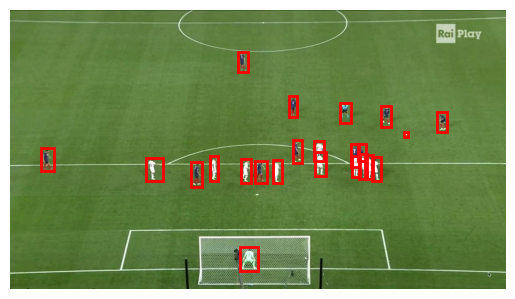

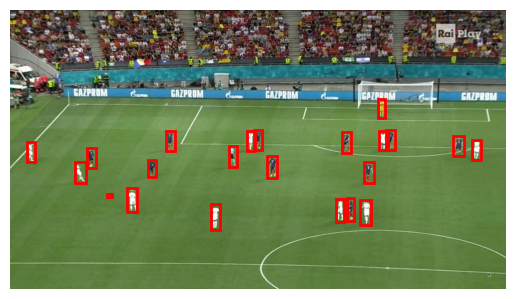

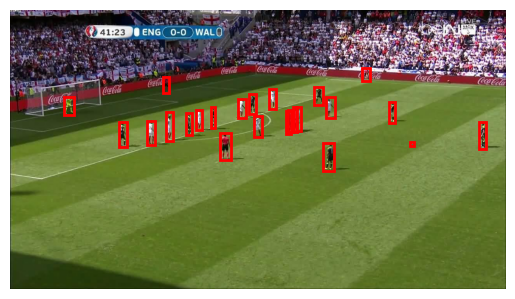

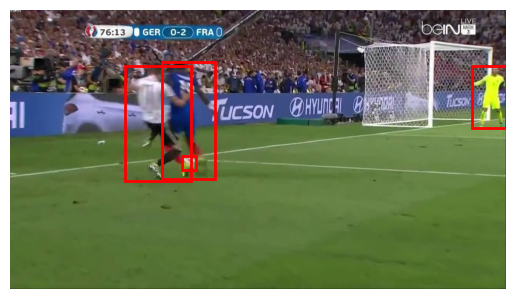

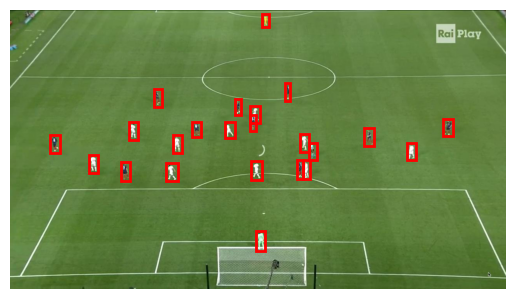

In [4]:
for i in range(5):  # Adjust the number to the number of images you want to visualize
    sample = ds['train'][i]  # Get the ith sample from the dataset
    image = sample['image']  # Get the image (PIL format)
    bboxes = sample['objects']['bbox']  # Get the bounding boxes
    
    # Convert the image to RGB (in case it's grayscale)
    if image.mode != 'RGB':
        image = image.convert('RGB')
    
    # Visualize the image with bounding boxes
    utils.visualize_image_with_bboxes(image, bboxes)

# Convert the PIL image to a NumPy array
image_data = ds['train'][5]['image']
bboxes = ds['train'][5]['objects']['bbox']


 # Baseline Model
 As a baseline a simple object detector is implemented in tensorflow

In [6]:
DROPOUT_FACTOR = 0.5
CLASSES = 2
def build_feature_extractor(inputs):

    x = tf.keras.layers.Conv2D(16, kernel_size=3, activation='relu', input_shape=(height, width, 1))(inputs)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)

    x = tf.keras.layers.Conv2D(32, kernel_size=3, activation = 'relu')(x)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)

    x = tf.keras.layers.Conv2D(64, kernel_size=3, activation = 'relu')(x)
    x = tf.keras.layers.Dropout(DROPOUT_FACTOR)(x)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)

    return x

def build_model_adaptor(inputs):
    x = tf.keras.layers.Flatten()(inputs)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    return x

def build_classifier_head(inputs):
    return tf.keras.layers.Dense(CLASSES, activation='softmax', name = 'classifier_head')(inputs)

def build_regressor_head(inputs):
    return tf.keras.layers.Dense(units = '4', name = 'regressor_head')(inputs)

def build_model(inputs):
    
    feature_extractor = build_feature_extractor(inputs)

    model_adaptor = build_model_adaptor(feature_extractor)

    classification_head = build_classifier_head(model_adaptor)

    regressor_head = build_regressor_head(model_adaptor)

    model = tf.keras.Model(inputs = inputs, outputs = [classification_head, regressor_head])

    model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss = {'classifier_head' : 'categorical_crossentropy', 'regressor_head' : 'mse' }, 
              metrics = {'classifier_head' : 'accuracy', 'regressor_head' : 'mse' })

    return model

In [7]:
height,width = 720,1280
model = build_model(tf.keras.layers.Input(shape=(width, height, 1)))

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 1280, 720, 1)]       0         []                            
                                                                                                  
 conv2d_3 (Conv2D)           (None, 1278, 718, 16)        160       ['input_2[0][0]']             
                                                                                                  
 average_pooling2d_3 (Avera  (None, 639, 359, 16)         0         ['conv2d_3[0][0]']            
 gePooling2D)                                                                                     
                                                                                                  
 conv2d_4 (Conv2D)           (None, 637, 357, 32)         4640      ['average_pooling2d_3[0]

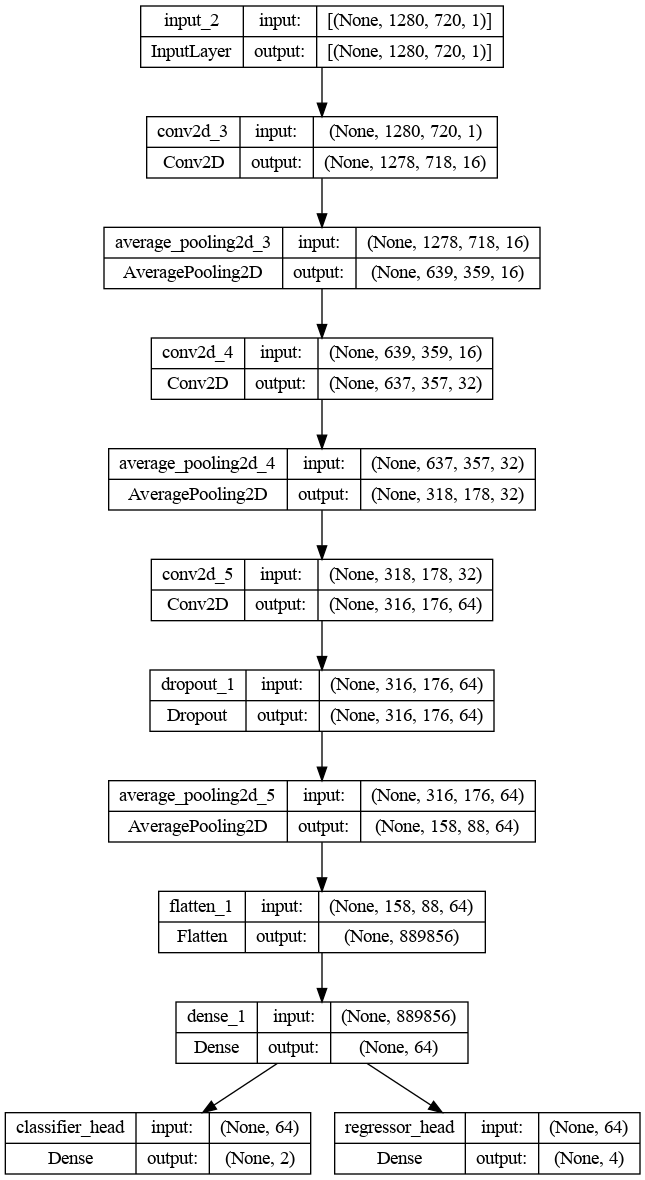

In [8]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True)

In [11]:
#model = build_model(tf.keras.layers.Input(shape=(input_size, input_size, 1,)))

model.compile(optimizer=tf.keras.optimizers.Adam(), 
    loss = {'classifier_head' : 'categorical_crossentropy', 'regressor_head' : 'mse' }, 
    metrics = {'classifier_head' : 'accuracy', 'regressor_head' : 'mse' })
    
EPOCHS = 100
BATCH_SIZE = 4

history = model.fit(ds['train'],
                    steps_per_epoch=(len(ds['train']) // BATCH_SIZE),
                    validation_data=ds['validation'], validation_steps=1, 
                    epochs=EPOCHS)

ValueError: Failed to find data adapter that can handle input: <class 'datasets.arrow_dataset.Dataset'>, <class 'NoneType'>